<a href="https://colab.research.google.com/github/praivesi/kaggler/blob/main/kaggler_titanic_expert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

#전처리 및 머신러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

# 경고 제거 (Pandas 귀찮은 경고들)
import sys
import warnings 

warnings.filterwarnings('ignore')

<ipython-input-3-393ad3a95d7f>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [5]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
ntrain = train.shape[0]
ntest = train.shape[0]

y_train = train['Survived'].values
passId = test['PassengerId']

data = pd.concat((train, test))

print('data size is : {}'.format(data.shape))

data size is : (1309, 12)


In [11]:
# 도움되는 EDA용 함수들
train.dtypes
train.columns
train.head()
train.tail()
train.info()
train.describe
train.describe()
train[3:5]
train['Survived'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


0    549
1    342
Name: Survived, dtype: int64

<Axes: >

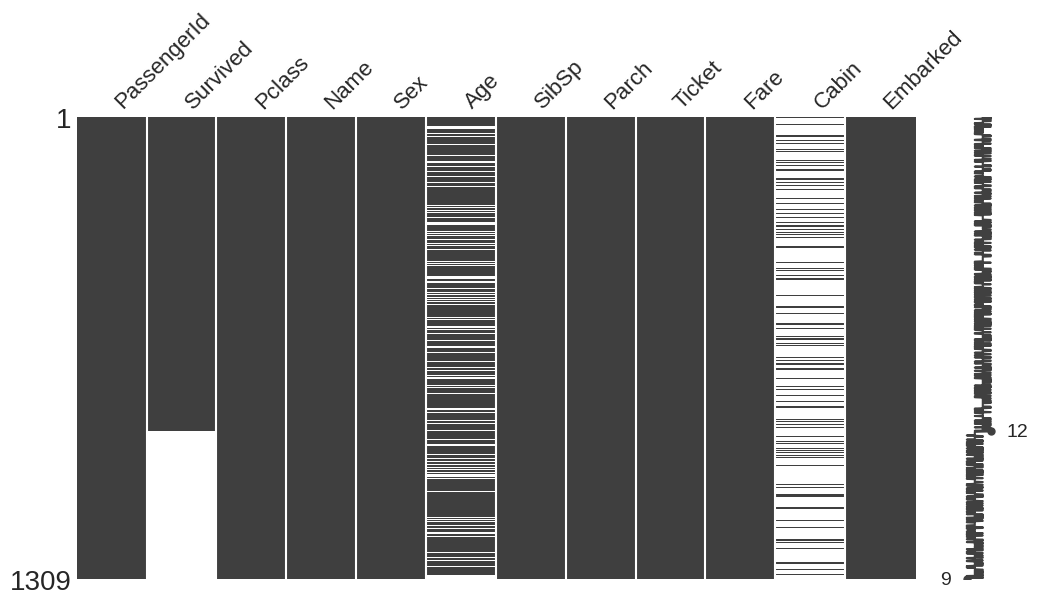

In [14]:
missingno.matrix(data, figsize=(12,6))

In [15]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [22]:
data.Age.isnull().any()

True

In [23]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

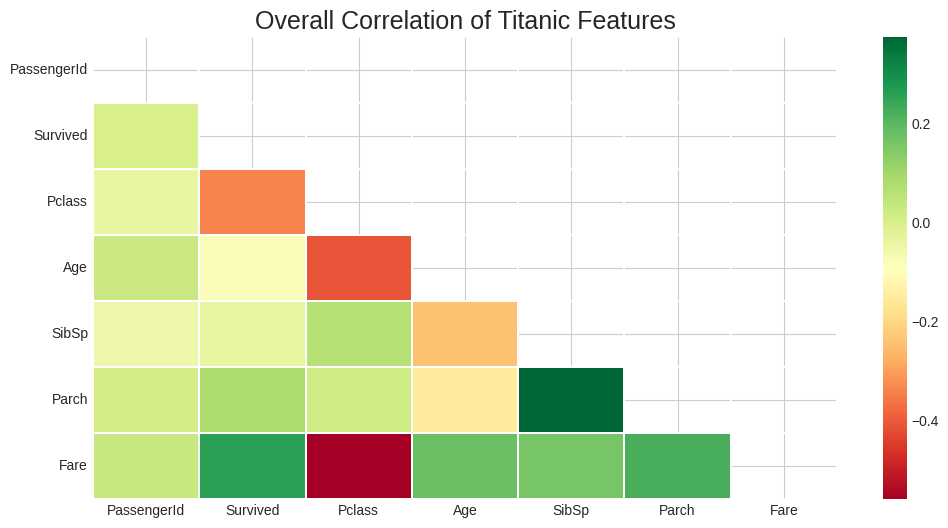

In [24]:
corr = data.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,6))
plt.title('Overall Correlation of Titanic Features', fontsize=18)

sns.heatmap(corr, mask = mask, annot = False, cmap='RdYlGn', linewidths=0.2, annot_kws={'size' : 20})
plt.show()


0    549
1    342
Name: Survived, dtype: int64


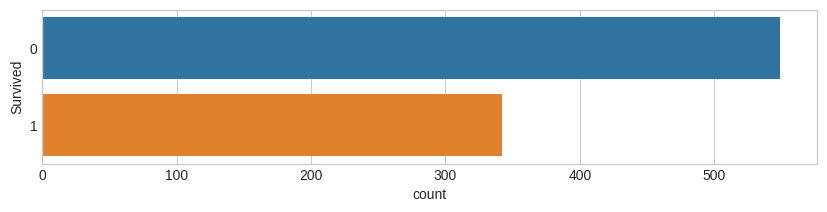

In [26]:
fig = plt.figure(figsize=(10, 2))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

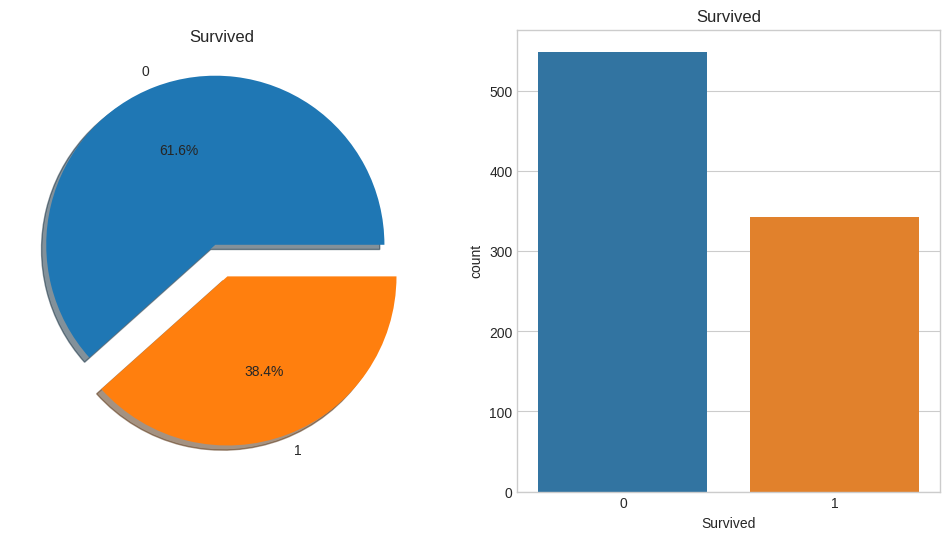

In [37]:
def piecount(col):
  f, ax = plt.subplots(1, 2, figsize=(12,6))
  train[col].value_counts().plot.pie(explode=[0.1 for i in range(train[col].nunique())], autopct='%1.1f%%', ax=ax[0], shadow=True)
  ax[0].set_title(col)
  ax[0].set_ylabel('')
  sns.countplot(x=col, data=train, ax=ax[1])
  ax[1].set_title(col)
  plt.show()

piecount('Survived')

In [39]:
train.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [41]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


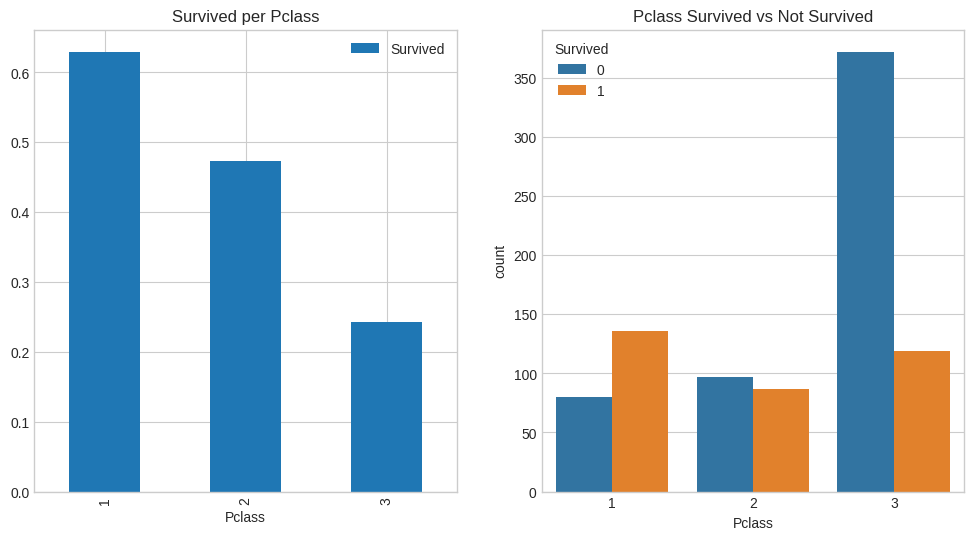

In [43]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
train[['Pclass', 'Survived']].groupby(['Pclass']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived per Pclass')
sns.countplot(x = 'Pclass', hue = 'Survived', data = train, ax = ax[1])
ax[1].set_title('Pclass Survived vs Not Survived')
plt.show()

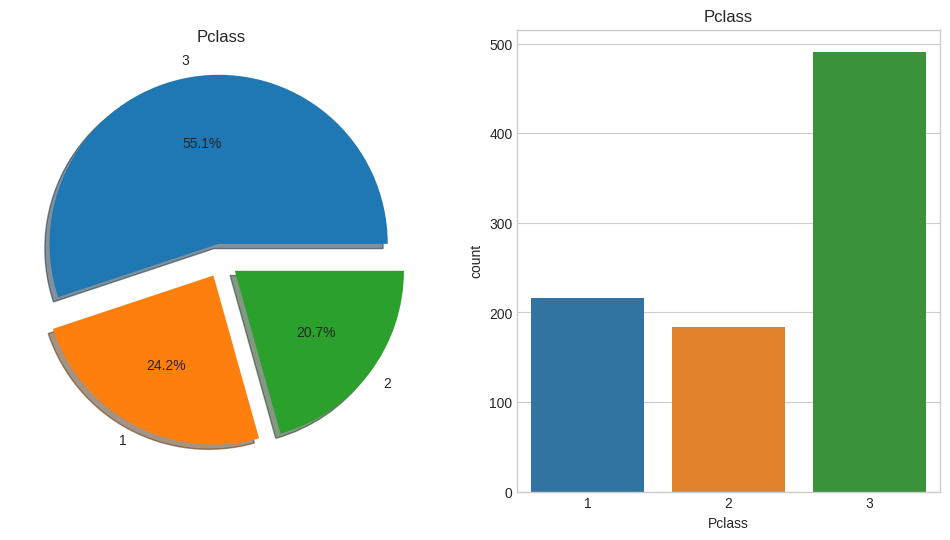

In [44]:
piecount('Pclass')

In [46]:
temp = data.copy()
temp['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')
temp['Initial'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Initial, dtype: int64

In [47]:
pd.crosstab(temp.Initial, temp.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [48]:
def survpct(col):
  return temp.groupby(col)['Survived'].mean()

survpct('Initial')

Initial
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dona             NaN
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

In [49]:
# 뭘할진 모르겠지만 일단 이름이 뭔가 생존율의 힌트를 줄 수 있을 것 같으니 Lastname(성) 도 뽑아서 확인해보자.
temp['Lastname'] = data.Name.str.extract('([A-Za-z]+)')
pd.crosstab(temp.Lastname, temp.Survived).T.style.background_gradient(cmap='summer_r')

In [50]:
temp.loc[temp['Initial'] == 'Dona']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,Dona,Oliva


In [51]:
temp.loc[temp['Initial'] == 'Dona', 'Initial'] = 'Mrs'

In [52]:
temp.loc[temp['Initial'] == 'Dona'] # 이젠 없음f

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname


In [53]:
pd.crosstab(temp.Initial, temp.Survived).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0.000000,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0
1.000000,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1


In [54]:
temp['NumName'] = temp['Lastname'].factorize()[0]

In [56]:
pd.crosstab(temp.NumName, temp.Survived).T.style.background_gradient(cmap='summer_r')

NumName,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,2,0,0,1,1,2,1,4,3,1,0,0,1,7,1,0,5,4,4,0,1,0,0,0,1,1,2,5,1,1,0,0,1,2,1,0,1,0,1,2,1,1,0,1,1,1,2,6,1,1,0,1,0,0,1,1,6,1,0,2,6,1,0,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,0,1,4,1,1,1,1,1,1,1,1,1,0,0,1,1,2,2,3,4,1,0,0,1,1,2,1,2,2,1,1,1,3,1,1,1,0,0,1,1,1,1,0,1,1,0,1,1,3,0,1,1,1,1,1,1,1,1,1,2,3,0,1,1,7,1,0,1,2,1,0,1,1,4,1,3,1,4,1,1,1,1,0,1,0,3,1,0,1,0,1,0,1,0,1,2,1,1,0,2,0,0,0,2,0,1,1,1,1,0,1,0,0,1,1,1,1,1,0,1,1,2,1,1,1,1,1,1,1,0,1,1,1,1,0,0,2,1,1,2,2,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,1,2,1,0,1,1,0,0,0,0,1,1,1,1,1,2,0,1,0,1,0,1,1,0,0,0,1,1,2,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,1,1,0,0,1,1,3,1,1,0,1,0,0,1,2,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0,1,1,2,0,1,0,0,1,1,0,0,1,2,1,1,0,1,1,1,0,1,0,0,1,1,1,1,2,1,0,0,2,0,0,1,0,1,1,1,1,1,0,0,0,0,0,0,2,1,0,1,0,1,0,0,0,2,1,1,1,1,1,1,1,1,2,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,2,1,1,0,0,0,0,0,0,0,

In [59]:
temp.loc[temp['Lastname'] == 'Ali']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName
210,211,0.0,3,"Ali, Mr. Ahmed",male,24.0,0,0,SOTON/O.Q. 3101311,7.05,NaN,S,Mr,Ali,182
784,785,0.0,3,"Ali, Mr. William",male,25.0,0,0,SOTON/O.Q. 3101312,7.05,NaN,S,Mr,Ali,182


In [60]:
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [61]:
def bag(col, target, title, title1):
  f, ax = plt.subplots(1, 2, figsize=(12,6))
  train.groupby([col])[target].mean().plot(kind='bar', ax=ax[0])
  ax[0].set_title(title)
  sns.countplot(x=col, hue=target, data=train, ax=ax[1])
  ax[1].set_title(title1)
  plt.show()

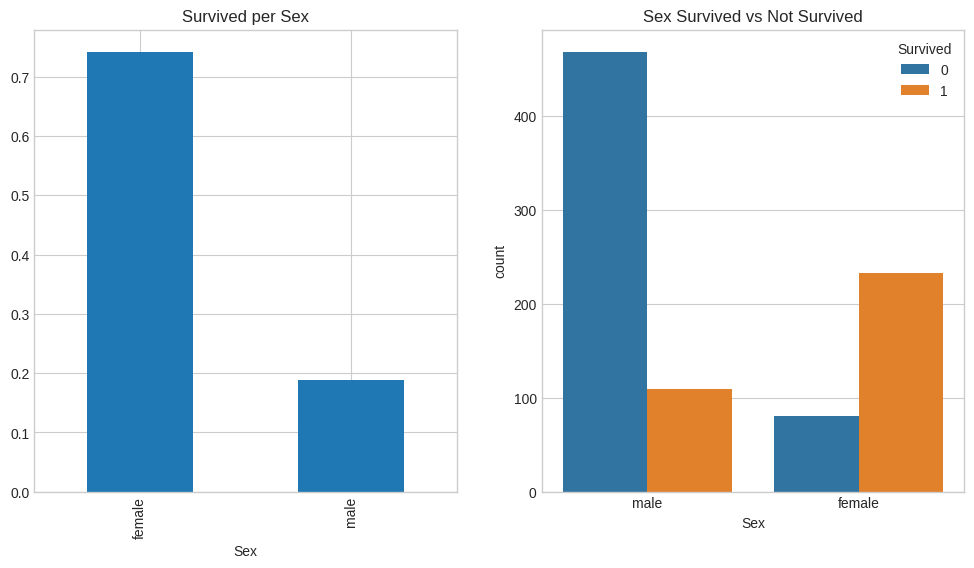

In [62]:
bag('Sex', 'Survived', 'Survived per Sex', 'Sex Survived vs Not Survived')

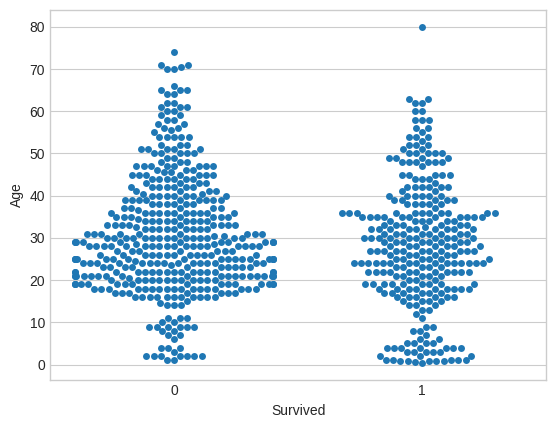

In [63]:
sns.swarmplot(x=train['Survived'], y=train['Age'])
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

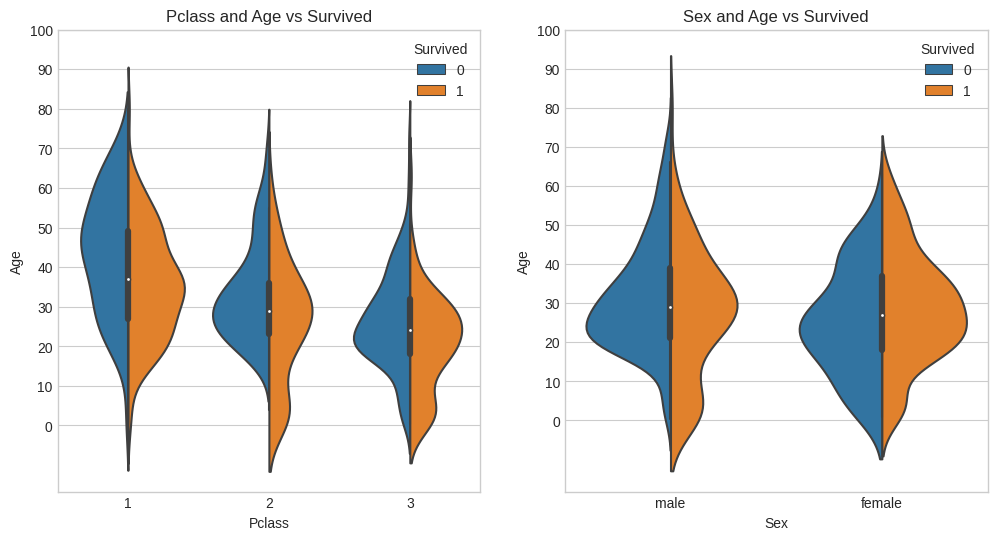

In [66]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

In [67]:
temp.groupby('Initial').agg({'Age' : ['mean', 'count']}) # 이니셜별 평균 연령 체크

Age      
               mean count
Initial                  
Capt      70.000000     1
Col       54.000000     4
Countess  33.000000     1
Don       40.000000     1
Dr        43.571429     7
Jonkheer  38.000000     1
Lady      48.000000     1
Major     48.500000     2
Master     5.482642    53
Miss      21.774238   210
Mlle      24.000000     2
Mme       24.000000     1
Mr        32.252151   581
Mrs       37.005848   171
Ms        28.000000     1
Rev       41.250000     8
Sir       49.000000     1

In [69]:
# 이니셜별 평균 연령을 결측 Age에 할당
temp = temp.reset_index(drop=True)
temp['Age'] = temp.groupby('Initial')['Age'].apply(lambda x: x.fillna(x.mean()))
temp[31:50]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Lastname,NumName
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,37.005848,1,0,PC 17569,146.5208,B78,C,Mrs,Spencer,30
32,33,1.0,3,"Glynn, Miss. Mary Agatha",female,21.774238,0,0,335677,7.7500,NaN,Q,Miss,Glynn,31
33,34,0.0,2,"Wheadon, Mr. Edward H",male,66.000000,0,0,C.A. 24579,10.5000,NaN,S,Mr,Wheadon,32
34,35,0.0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,NaN,C,Mr,Meyer,33
35,36,0.0,1,"Holverson, Mr. Alexander Oskar",male,42.000000,1,0,113789,52.0000,NaN,S,Mr,Holverson,34
36,37,1.0,3,"Mamee, Mr. Hanna",male,32.252151,0,0,2677,7.2292,NaN,C,Mr,Mamee,35
37,38,0.0,3,"Cann, Mr. Ernest Charles",male,21.000000,0,0,A./5. 2152,8.0500,NaN,S,Mr,Cann,36
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",female,18.000000,2,0,345764,18.0000,NaN,S,Miss,Vander,18
39,40,1.0,3,"Nicola-Yarred, Miss. Jamila",female,14.000000,1,0,2651,11.2417,NaN,C,Miss,Nicola,37
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.000000,1,0,7546,9.4750,NaN,S,Mrs,Ahlin,38
